In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from simulation_influenza import Main
#%load_ext autoreload
#%autoreload 2

In [18]:
def seir_model(y, ts, beta, sigma, gamma, 
               stype='stoch', beta_t=False):
    res = np.zeros((ts.shape[0], 4))
    res[0] = y
    beta_val = beta
    
    for time_stamp in ts[:-1]:
        if beta_t:
            beta_val = beta[time_stamp]
            
        if stype=='stoch':
            res[time_stamp+1] = seir_one_day_stoch(res[time_stamp], 
                                         beta_val, sigma, gamma)
        else:
            res[time_stamp+1] = seir_one_day(res[time_stamp], 
                                         beta_val, sigma, gamma)
        
    return res

def seir_one_day_stoch(y, beta, sigma, gamma):
    
    S, E, I, R = y
    b_s_i = np.random.binomial(S, np.min([beta*I,1]))
    sigma_e = np.random.binomial(E, sigma)
    gamma_i = np.random.binomial(I, gamma)
    
    dSdt = -b_s_i
    dEdt = b_s_i - sigma_e
    dIdt = sigma_e - gamma_i
    dRdt = gamma_i
    
    #S = np.max([S + dSdt, 0])
    S += dSdt
    E += dEdt
    I += dIdt
    R += dRdt
    
    return [S, E, I, R]


def seir_one_day(y, beta, sigma, gamma):
    
    S, E, I, R = y
    
    dSdt = -beta * S * I
    dEdt = beta * S * I - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    
    S = np.max([S + dSdt, 0])
    #S += dSdt
    E += dEdt
    I += dIdt
    R += dRdt
    
    return [S, E, I, R]

In [123]:
pool = Main(
        strains_keys  = ['H1N1', 'H3N2', 'B'], 
        infected_init = [10, 0, 0], 
        alpha         = [0.78, 0.74, 0.6], 
        lmbd          = 0.4
        )

pool.runs_params(
        num_runs = 6, 
        days = [1, 50],
        data_folder = 'synthetic_sample_4000',
        )

pool.age_groups_params(
        age_groups = ['0-10', '11-17', '18-59', '60-150'], 
        vaccined_fraction = [0, 0, 0, 0]
        )

pool.start(with_seirb=True)

Directory already exists!

      sp_id  sp_hh_id  age  sex  work_id  susceptible_H1N1  susceptible_H3N2  \
143     144       474   91    0      973                 0                 1   
1229   1230       145   55    0      910                 0                 1   
824     825       180   42    1      346                 0                 1   
3278   3279       671   31    0      909                 0                 1   
1540   1541       596   99    0      726                 0                 1   
...     ...       ...  ...  ...      ...               ...               ...   
2969   2970       844   66    1      458                 0                 1   
3977   3978       311   52    0     1018                 0                 1   
1453   1454       202   26    0      251                 0                 0   
3226   3227       821   76    1      971                 0                 0   
3500   3501       696   48    0      877                 0                 1   

      suscep

True

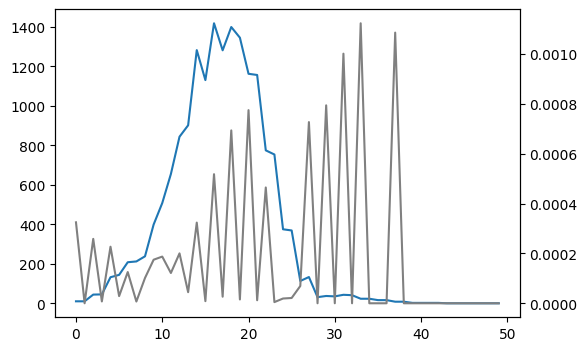

In [2]:
df = pd.read_csv('results/synthetic_sample_4000/seirb_seed_0.csv', 
                 sep='\t')

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(df.I_H1N1)
ax_beta = ax.twinx()
ax_beta.plot(df.beta_H1N1, color='gray')

<Axes: >

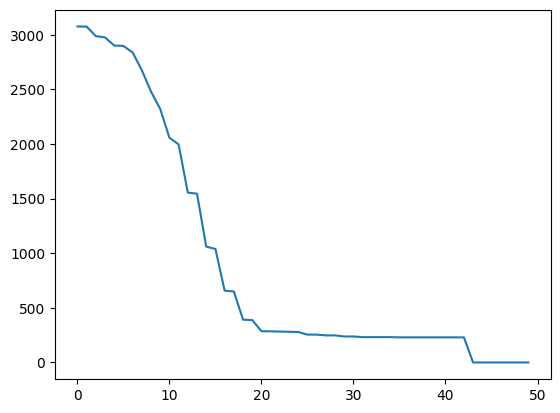

In [3]:
seed = 0
df_b = pd.read_csv(f'results/synthetic_sample_4000/seirb_seed_{seed}.csv', 
                 sep='\t')
df_b.S_H1N1.plot()

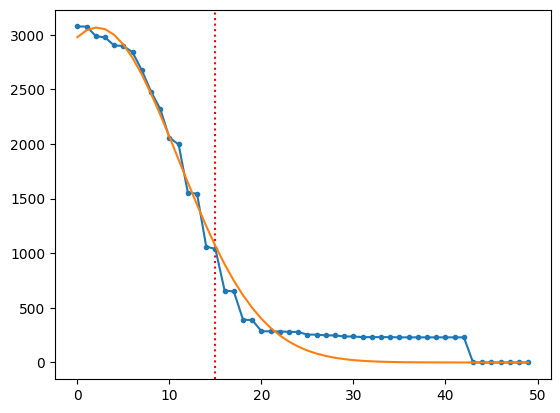

In [16]:
import numpy as np
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*np.exp(-b*x) + c

def func(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2) 

def find_vals(vals):
    y_data = vals
    x = np.arange(y_data.shape[0])
    popt, pcov = curve_fit(func, x, y_data)
    return popt

st_day = 15
popt = find_vals(df.S_H1N1[:st_day])

plt.axvline(st_day, ls=':', color='red')
plt.plot(df_b.S_H1N1, marker='.')

plt.plot(func(np.arange(df.shape[0]), *popt));

In [20]:
st_day=10
y = df.iloc[10,:4].values
ts = np.arange(df.shape[0]-st_day)
sigma=1/2
gamma=1/6
betas = df.beta_H1N1[st_day:].values

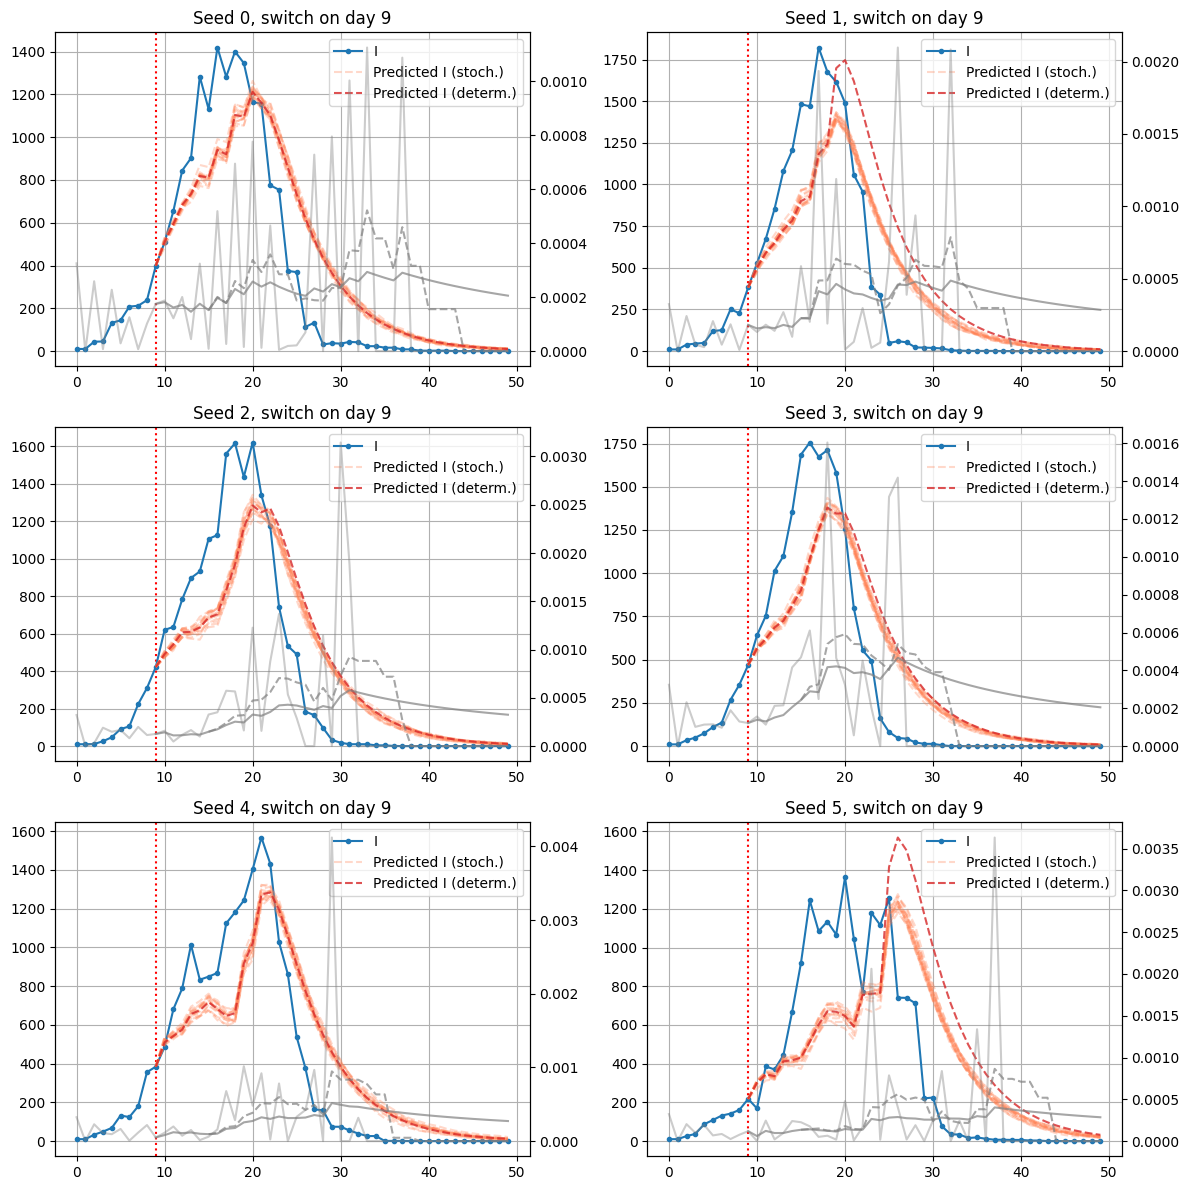

In [19]:
st_day=9

fig, axes = plt.subplots(3, 2, figsize=(12,12))
axes = axes.flatten()

sigma=1/2
gamma=1/6

for seed in range(6):
    df_b = pd.read_csv(f'results/synthetic_sample_4000/seirb_seed_{seed}.csv', 
                 sep='\t')
    ax = axes[seed]
    # time of switch + real data
    ax.axvline(st_day, ls=':', color='red')
    ax.plot(df_b.I_H1N1, label='I', color='tab:blue', marker='.')

    ax_beta = ax.twinx()
    betas = df_b.beta_H1N1[st_day:]
    ax_beta.plot(df_b.beta_H1N1, color='gray', alpha=0.4, label='beta from df')

    beta_expand_m = df_b.beta_H1N1[st_day:].expanding().mean()
    ax_beta.plot(beta_expand_m, color='gray',  label='beta expanding mean', alpha=0.7)

    beta_roll_m = df_b.beta_H1N1[st_day:].rolling(7).mean()
    ax_beta.plot(beta_roll_m, color='gray', ls='--', label='beta rolling mean', alpha=0.7)


    y0 = df_b.iloc[st_day,:4].values
    ts = np.arange(df.shape[0]-st_day)
    sigma=1/2
    gamma=1/6

    betas = betas.fillna(0).values
    #betas = beta_expand_m.fillna(0).values
    #betas = beta_roll_m.fillna(0).values
    for i in range(15):
        if i==0:
            label='Predicted I (stoch.)'
        else:
            label=''
        S,E,I,R = seir_model(y0, ts, betas, sigma, gamma, 
                              stype='stoch', beta_t=True).T

        ax.plot(ts+st_day, I, color='coral', ls='--', alpha=0.3, label=label)


    S,E,I,R = seir_model(y0, ts, betas, sigma, gamma, 
                         stype='d', beta_t=True).T
    ax.plot(ts+st_day, I, color='tab:red', ls='--', alpha=0.8, 
            label='Predicted I (determ.)')

    ax.legend()    
    ax.grid()
    
    ax.set_title(f'Seed {seed}, switch on day {st_day}')
    
fig.tight_layout()

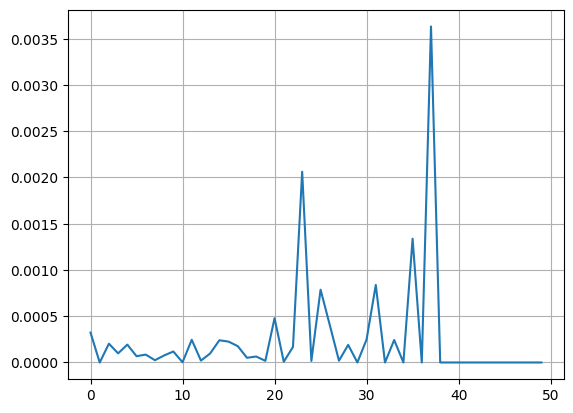

In [76]:
df_b.iloc[:,4].plot()
plt.grid()

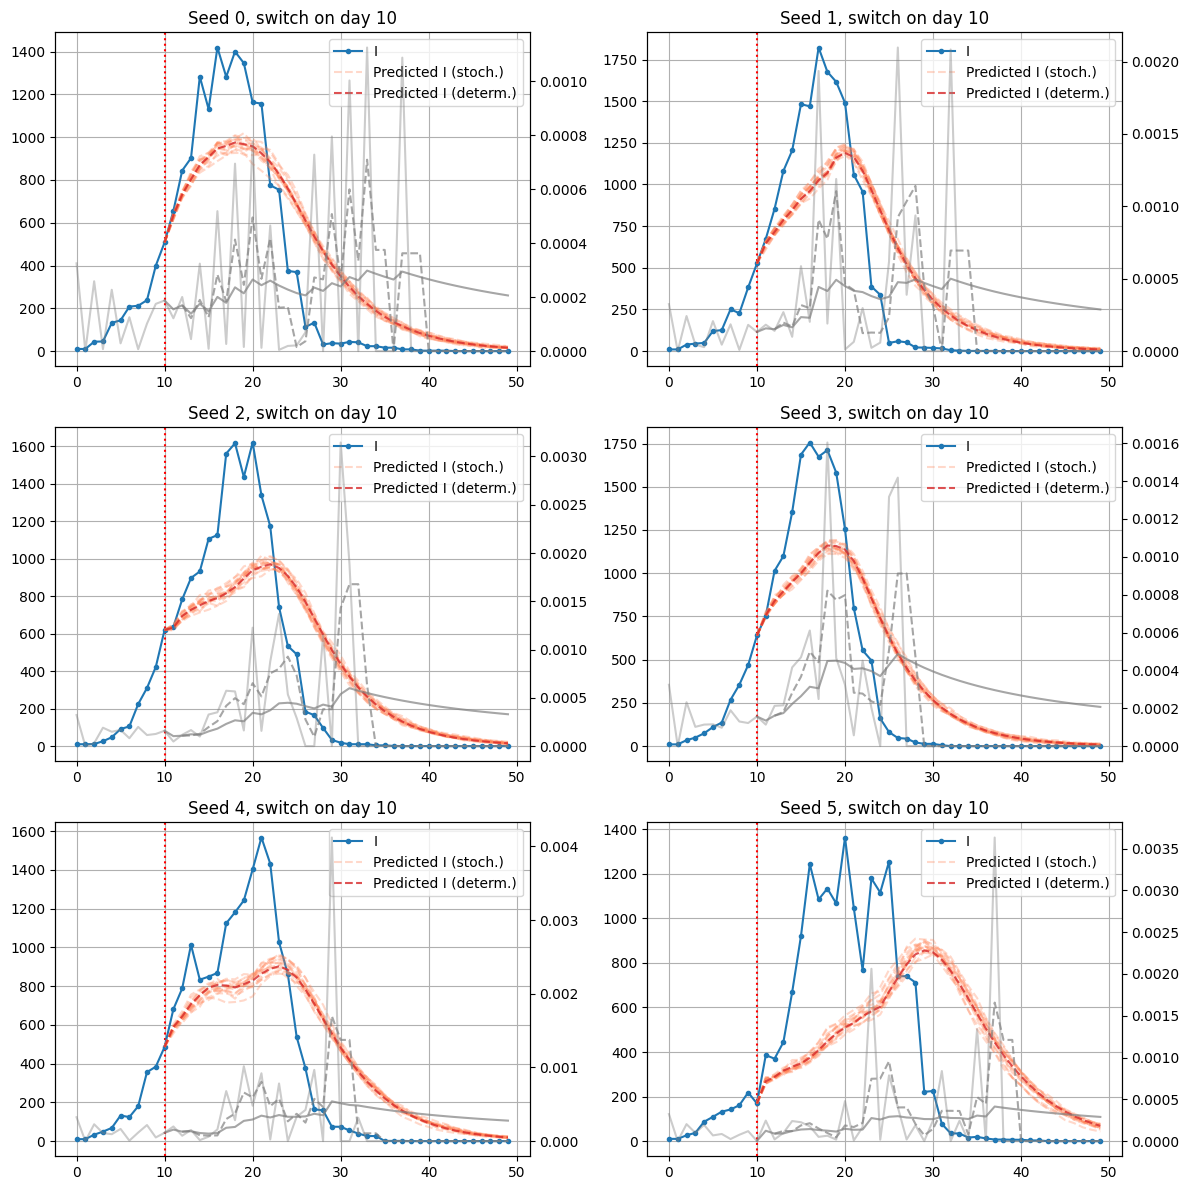

In [106]:
st_day=10

fig, axes = plt.subplots(3, 2, figsize=(12,12))
axes = axes.flatten()

sigma=1/2
gamma=1/6

for seed in range(6):
    df_b = pd.read_csv(f'results/synthetic_sample_4000/seirb_seed_{seed}.csv', 
                 sep='\t')
    ax = axes[seed]
    # time of switch + real data
    ax.axvline(st_day, ls=':', color='red')
    ax.plot(df_b.I_H1N1, label='I', color='tab:blue', marker='.')

    ax_beta = ax.twinx()
    betas = df_b.beta_H1N1[st_day:]
    ax_beta.plot(df_b.beta_H1N1, color='gray', alpha=0.4, label='beta from df')

    beta_expand_m = df_b.beta_H1N1[st_day:].expanding().mean()
    ax_beta.plot(beta_expand_m, color='gray',  label='beta expanding mean', alpha=0.7)

    beta_roll_m = df_b.beta_H1N1[st_day:].rolling(3).mean()
    ax_beta.plot(beta_roll_m, color='gray', ls='--', label='beta rolling mean', alpha=0.7)


    y0 = df_b.iloc[st_day,:4].values
    ts = np.arange(df.shape[0]-st_day)
    sigma=1/2
    gamma=1/6

    betas = betas.fillna(0).values
    betas = beta_expand_m.fillna(0).values
    #betas = beta_roll_m.fillna(0).values
    for i in range(15):
        if i==0:
            label='Predicted I (stoch.)'
        else:
            label=''
        S,E,I,R = seir_model(y0, ts, betas, sigma, gamma, 
                              stype='stoch', beta_t=True).T

        ax.plot(ts+st_day, I, color='coral', ls='--', alpha=0.3, label=label)


    S,E,I,R = seir_model(y0, ts, betas, sigma, gamma, 
                         stype='d', beta_t=True).T
    ax.plot(ts+st_day, I, color='tab:red', ls='--', alpha=0.8, 
            label='Predicted I (determ.)')

    ax.legend()    
    ax.grid()
    
    ax.set_title(f'Seed {seed}, switch on day {st_day}')
    
fig.tight_layout()

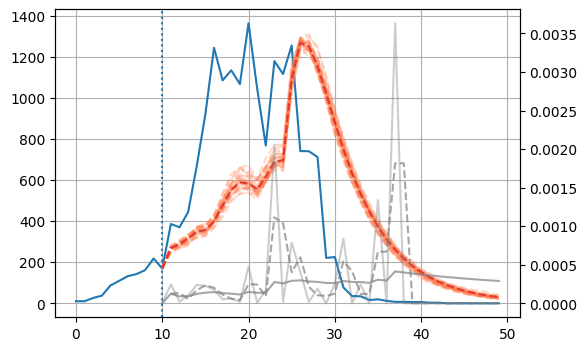

In [100]:
st_day=10

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(df_b.iloc[:,2])
ax.axvline(st_day,ls=':')


ax_beta = ax.twinx()
y0 = df_b.iloc[st_day,:4].values
ts = np.arange(df.shape[0]-st_day)

betas = df_b.beta_H1N1[st_day:]
beta_expand_m = df_b.beta_H1N1[st_day:].expanding().mean()
beta_roll_m = df_b.beta_H1N1[st_day:].rolling(2).mean()

ax_beta.plot(betas, color='gray', alpha=0.4, label='beta from df')
ax_beta.plot(beta_expand_m, color='gray',  label='beta expanding mean', alpha=0.7)
ax_beta.plot(beta_roll_m, color='gray', ls='--', label='beta rolling mean', alpha=0.7)

betas = betas.fillna(0).values
betas = beta_expand_m.fillna(0).values
betas = beta_roll_m.fillna(0).values
for i in range(30):
    S,E,I,R = seir_model(y0, ts, betas, sigma, gamma, 
                                  stype='stoch', beta_t=True).T

    ax.plot(ts+st_day, I, color='coral', ls='--', alpha=0.3, 
             label=label)

S,E,I,R = seir_model(y0, ts, betas, sigma, gamma, 
                         stype='d', beta_t=True).T
ax.plot(ts+st_day, I, color='tab:red', ls='--', alpha=0.8, 
        label='Predicted I (determ.)')
ax.grid()

## expanding beta

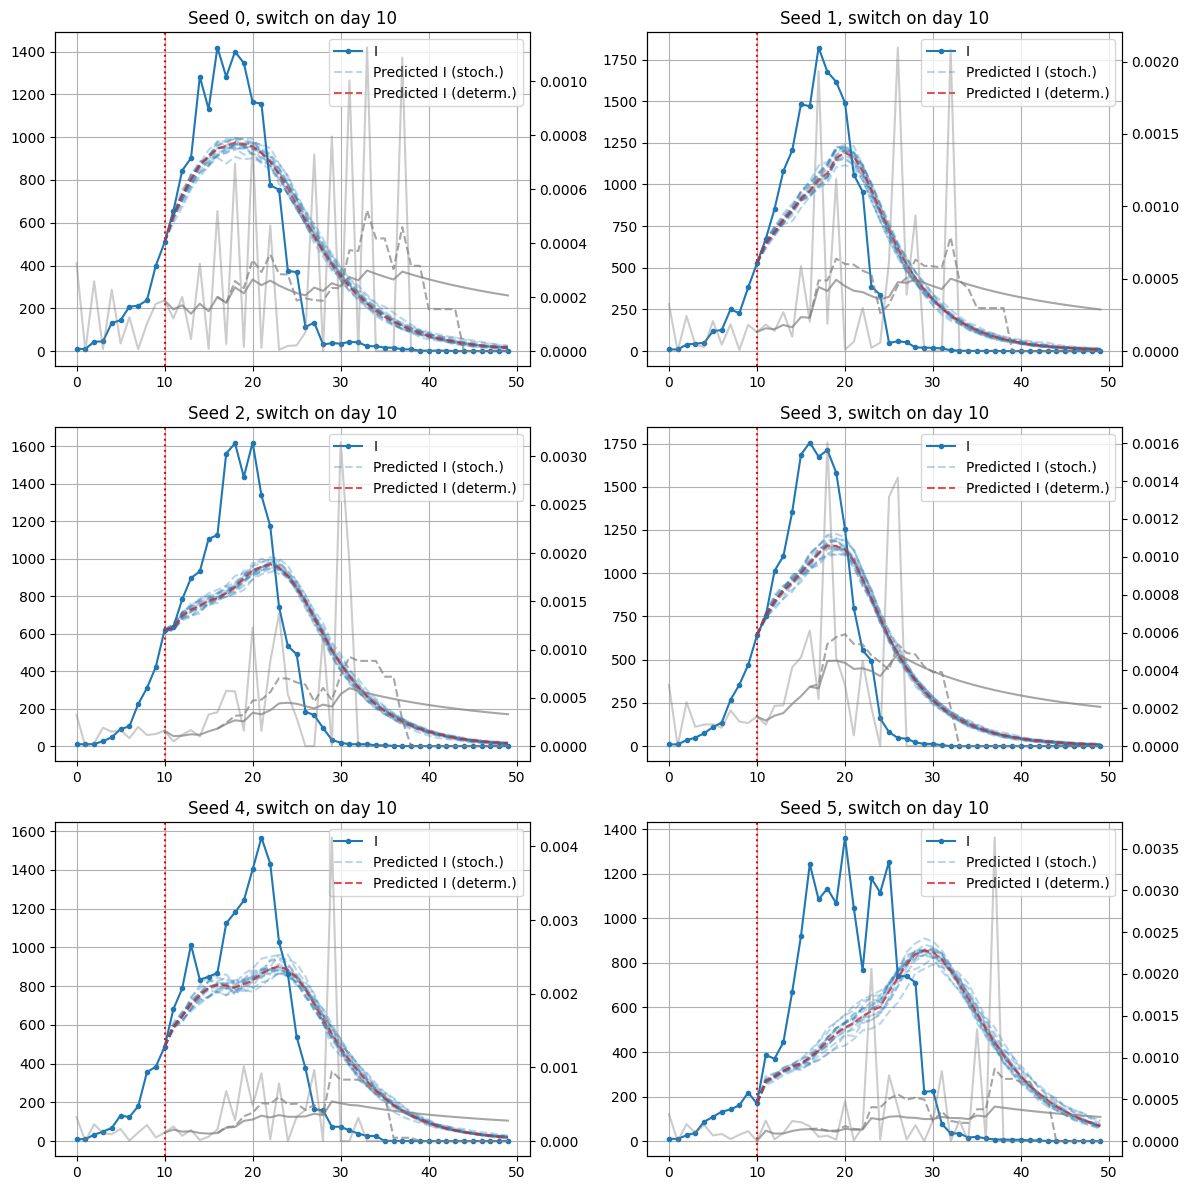

In [135]:
st_day=10

fig, axes = plt.subplots(3, 2, figsize=(12,12))
axes = axes.flatten()

sigma=1/2
gamma=1/6

for seed in range(6):
    df_b = pd.read_csv(f'results/synthetic_sample_4000/seirb_seed_{seed}.csv', 
                 sep='\t')
    ax = axes[seed]
    # time of switch + real data
    ax.axvline(st_day, ls=':', color='red')
    ax.plot(df_b.I_H1N1, label='I', color='tab:blue', marker='.')

    ax_beta = ax.twinx()
    betas = df_b.beta_H1N1[st_day:]
    ax_beta.plot(df_b.beta_H1N1, color='gray', alpha=0.4, label='beta from df')

    beta_expand_m = df_b.beta_H1N1[st_day:].expanding().mean()
    ax_beta.plot(beta_expand_m, color='gray',  label='beta expanding mean', alpha=0.7)

    beta_roll_m = df_b.beta_H1N1[st_day:].rolling(7).mean()
    ax_beta.plot(beta_roll_m, color='gray', ls='--', label='beta rolling mean', alpha=0.7)


    y0 = df_b.iloc[st_day,:4].values
    ts = np.arange(df.shape[0]-st_day)
    sigma=1/2
    gamma=1/6

    betas = betas.fillna(0).values
    betas = beta_expand_m.fillna(0).values
    #betas = beta_roll_m.fillna(0).values
    for i in range(15):
        if i==0:
            label='Predicted I (stoch.)'
        else:
            label=''
        S,E,I,R = seir_model(y0, ts, betas, sigma, gamma, 
                              stype='stoch', beta_t=True).T

        ax.plot(ts+st_day, I, color='tab:blue', ls='--', alpha=0.3, label=label)


    S,E,I,R = seir_model(y0, ts, betas, sigma, gamma, 
                         stype='d', beta_t=True).T
    ax.plot(ts+st_day, I, color='tab:red', ls='--', alpha=0.8, 
            label='Predicted I (determ.)')

    ax.legend()    
    ax.grid()
    
    ax.set_title(f'Seed {seed}, switch on day {st_day}')
    
fig.tight_layout()

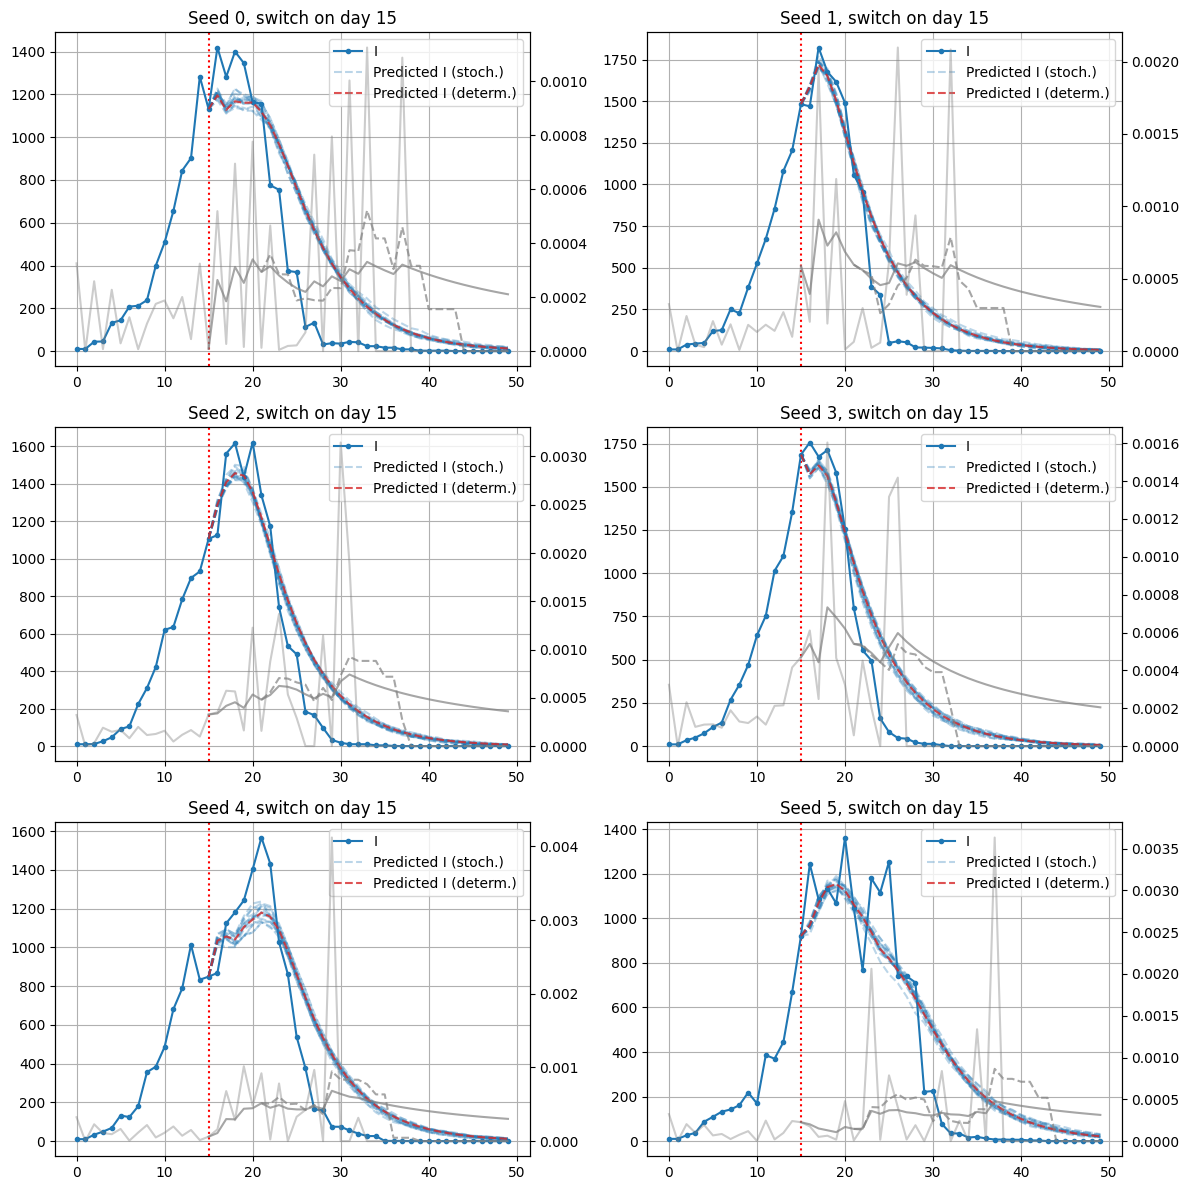

In [136]:
st_day=15

fig, axes = plt.subplots(3, 2, figsize=(12,12))
axes = axes.flatten()

sigma=1/2
gamma=1/6

for seed in range(6):
    df_b = pd.read_csv(f'results/synthetic_sample_4000/seirb_seed_{seed}.csv', 
                 sep='\t')
    ax = axes[seed]
    # time of switch + real data
    ax.axvline(st_day, ls=':', color='red')
    ax.plot(df_b.I_H1N1, label='I', color='tab:blue', marker='.')

    ax_beta = ax.twinx()
    betas = df_b.beta_H1N1[st_day:]
    ax_beta.plot(df_b.beta_H1N1, color='gray', alpha=0.4, label='beta from df')

    beta_expand_m = df_b.beta_H1N1[st_day:].expanding().mean()
    ax_beta.plot(beta_expand_m, color='gray',  label='beta expanding mean', alpha=0.7)

    beta_roll_m = df_b.beta_H1N1[st_day:].rolling(7).mean()
    ax_beta.plot(beta_roll_m, color='gray', ls='--', label='beta rolling mean', alpha=0.7)


    y0 = df_b.iloc[st_day,:4].values
    ts = np.arange(df.shape[0]-st_day)
    sigma=1/2
    gamma=1/6

    betas = betas.fillna(0).values
    betas = beta_expand_m.fillna(0).values
    #betas = beta_roll_m.fillna(0).values
    for i in range(15):
        if i==0:
            label='Predicted I (stoch.)'
        else:
            label=''
        S,E,I,R = seir_model(y0, ts, betas, sigma, gamma, 
                              stype='stoch', beta_t=True).T

        ax.plot(ts+st_day, I, color='tab:blue', ls='--', alpha=0.3, label=label)


    S,E,I,R = seir_model(y0, ts, betas, sigma, gamma, 
                         stype='d', beta_t=True).T
    ax.plot(ts+st_day, I, color='tab:red', ls='--', alpha=0.8, 
            label='Predicted I (determ.)')

    ax.legend()    
    ax.grid()
    
    ax.set_title(f'Seed {seed}, switch on day {st_day}')
    
fig.tight_layout()

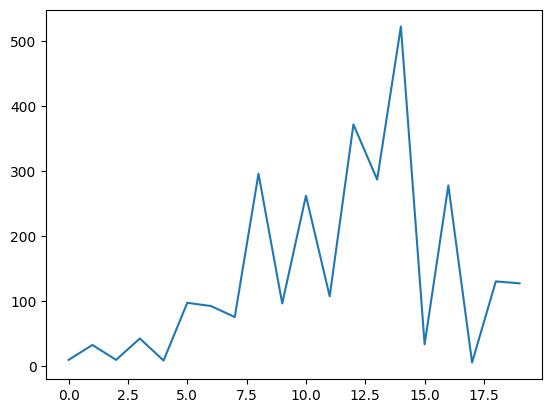

In [7]:
data = pd.read_csv('results/synthetic_sample_4000/incidence_seed_0.csv', sep='\t')

plt.plot(data['H1N1'])

In [9]:
Main(
        strains_keys  = ['H1N1', 'H3N2', 'B'], 
        infected_init = [10, 0, 0], 
        alpha         = [0.78, 0.74, 0.6], 
        lmbd          = 0.4
        )

In [8]:
data

,H1N1,H3N2,B
0,9,0,0
1,32,0,0
2,9,0,0
3,42,0,0
4,8,0,0
5,97,0,0
6,92,0,0
7,75,0,0
8,296,0,0
9,96,0,0
